# Exploring the Dataset

The speech samples are already divided into training, development, and test splits. The splits are made in such way that evaluation speakers are not present in training split. We are supposed to use the splits as they are.

In [26]:
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt, IPython.display as ipd
from sklearn  import preprocessing

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

## 1. Data Overview
We give a short overview of the overall structure of the dataset.

In [27]:
# read tsv file into a dataframe
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [28]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


We now take a look at the label distribution over each of the three splits. As we can see, there are 3000 `.wav` audio files in the project recorded from six speakers with 300 files for each of the ten classes.

In [29]:
# Count labels in each set.
dev_label_counts = sdr_df.where(sdr_df.split == "DEV").label.value_counts()
train_label_counts = sdr_df.where(sdr_df.split == "TRAIN").label.value_counts()
test_label_counts = sdr_df.where(sdr_df.split == "TEST").label.value_counts()
# Make a dataframe with the counts that sorts columns by their numerical value
label_counts = (pd.DataFrame([dev_label_counts, train_label_counts, test_label_counts], index=["DEV", "TRAIN", "TEST"])
                .sort_index(axis=1)
                .astype(int))
# Add a column with the total and a row with the total
label_counts["TOTAL"] = label_counts.sum(axis=1)
label_counts.loc["TOTAL"] = label_counts.sum(axis=0)

print("Speakers: ",set(sdr_df.speaker.values), "\n")
print("Label distribution:")
label_counts

Speakers:  {'yweweler', 'nicolas', 'theo', 'jackson', 'george', 'lucas'} 

Label distribution:


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,TOTAL
DEV,47,45,46,54,54,50,54,53,44,50,497
TRAIN,200,200,200,200,200,200,200,200,200,200,2000
TEST,53,55,54,46,46,50,46,47,56,50,503
TOTAL,300,300,300,300,300,300,300,300,300,300,3000


## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continuous speech signal. We now take a closer look at one of the audio files by plotting the underlying waveform.

In [51]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

x, sr = librosa.load(sample_wav_file)
print(f"Sampling rate: {sr} Hz")
ipd.Audio(x, rate=sr)


Sampling rate: 22050 Hz


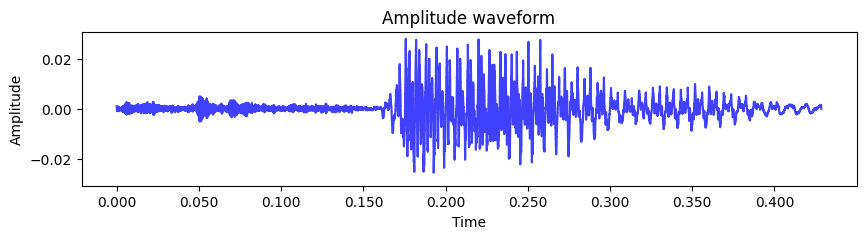

In [52]:
# plot as a waveform
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [41]:
print(f"Duration of sample in milliseconds: {(1000*len(x))/SAMPLING_RATE}")

Duration of sample in milliseconds: 428.5


## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain.

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds.

In [33]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr),
    and the number of mel coefficients, return a mel-scaled
    representation of the signal as numpy array.
    """

    mel_features = librosa.feature.melspectrogram(y=signal,
                                                  sr=sr,
                                                  n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
                                                  hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
                                                  n_mels=num_mels, # number of frequency bins, use either 13 or 39
                                                  fmin=50, # min frequency threshold
                                                  fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
                                                  )

    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)

    return scaled_log_mel_features

In [53]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=39)
print(f"Shape of spectogram: {melspectrogram.shape}")

Shape of spectogram: (39, 119)


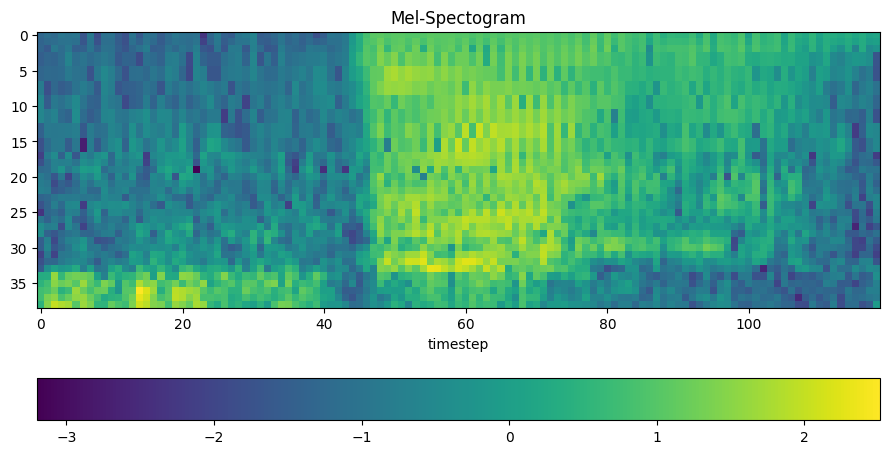

In [62]:
fig, ax = plt.subplots(figsize=(9,5))
# Create a heatmap with the counts
im = ax.imshow(melspectrogram)
# Create a colorbar
cbar = ax.figure.colorbar(im, ax=ax, orientation="horizontal")
ax.set_title("Mel-Spectogram")
ax.set_xlabel("timestep")
fig.tight_layout()
plt.show()